[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/LogisticRegression.ipynb)


# Logistic Regression
In logistic regression we perform binary classification of by learnig a function of the form $f_w(x) = \sigma(x^\top w)$. Here $x,w \in \mathbb{R}^D$, where $D$ is the number of features as before. $\sigma(z) = \frac{1}{1+e^{-z}}$ is the logistic function.  Let's plot this function below

In [2]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

Text(0.5, 1.0, 'logistic function')

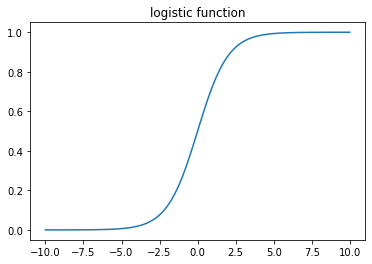

In [3]:
logistic = lambda z: 1./ (1 + np.exp(-z))
z = np.linspace(-10,10,100)
plt.plot(z, logistic(z))
plt.title('logistic function')

## Cost function
To fit our model $f_w$ to the data $\mathcal{D} = \{x^{(1)}, \ldots, x^{(N)}\}$, we maximize the **logarithm of the conditional likelihood**:

$$
\ell(w; \mathcal{D}) = \sum_n \log \mathrm{Bernoulli}(y^{(n)} | \sigma({x^{(n)}}^\top w)) = \sum_n y^{(n)} \log \sigma({x^{(n)}}^\top w)) + (1-y^{(n)}) \log (1-\sigma({x^{(n)}}^\top w)))
$$

by substituting the definition of logistic function in the equation above, and minimizing the **negative** of the log-likelihood, which is called the **cost function**,
we get

$$
J(w) = \sum_n y^{(n)} \log(1+e^{-x w^\top}) + (1-y^{(n)}) \log(1+e^{x w^\top})
$$

In practice we use mean rather than sum over data points.

In [4]:
def cost_fn(x, y, w):
    N, D = x.shape # not really used!
    z = np.dot(x, w) # N
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))
    return J

## Minimizing the cost using gradient descent
To minimize the cost we use gradient descent: start from some initial assignment to the parameters $w$, and at each iteration take a small step in the opposite direction of the *gradient*. The gradient of the cost function above is given by:

$$
\frac{\partial}{\partial w_d} J(w) =\sum_n - y^{(n)} x^{(n)}_d \frac{e^{-w^\top x^{(n)}}}{1 + e^{-w^\top x^{(n)}}} +x^{(n)}_d (1- y^{(n)}) \frac{e^{w^\top x^{(n)}}}{1 + e^{w^\top x^{(n)}}} = \sum_n - x^{(n)}_d y^{(n)} (1-\hat{y}^{(n)})+ x^{(n)}_d (1- y^{(n)}) \hat{y}^{(n)} = x^{(n)}_d (\hat{y}^{(n)} - y^{(n)}) 
$$
Since in practice we divide the cost by $N$, we have to the same for the gradient; see the implementation below.

In [5]:
def gradient(self, x, y):
    N,D = x.shape
    yh = logistic(np.dot(x, self.w))
    grad = np.dot(x.T, yh - y)/N
    return grad

## Logistic regression class
Now we are ready to implement the logistic regression class with the usual `fit` and `predict` methods. Here, the `fit` method implements gradient descent.

In [6]:
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iters = max_iters
        self.verbose = verbose
        
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            t += 1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))
        return yh

LogisticRegression.gradient = gradient

## Toy experiment

fit this linear model to toy data with $x \in \Re^1$ + a bias parameter

terminated after 100000 iterations, with norm of the gradient equal to 0.0007886436933334241
the weight found: [-9.96926826 20.27319341]


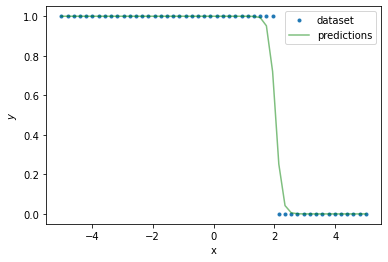

In [7]:
N = 20
x = np.linspace(-5,5, 50)
y = ( x < 2).astype(int)
model = LogisticRegression(verbose=True, )
yh = model.fit(x,y).predict(x)
plt.plot(x, y, '.', label='dataset')
plt.plot(x, yh, 'g', alpha=.5, label='predictions')
plt.xlabel('x')
plt.ylabel(r'$y$')
plt.legend()
plt.show()

we see that the model successfully fits the training data. If we run the optimization for long enough the weights will grow large (in absolute value) so as to make the predicted probabilities for the data-points close to the decidion boundary (x=2) close to zero and one.


## Weight Space
Similar to what we did for linear regression, we plot *cost* as a function for logistic regrression as a function of model parameters (weights), and show the correspondence between the different weights having different costs and their fit. 
The `plot_contour` is the same helper function we used for plotting the cost function for linear regression.

In [8]:
import itertools
def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i,j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    ax.contour(xg, yg, zg, 100)
    return ax

Now let's define the cost function for linear regression example above, and visualize the cost and the fit of various models (parameters).

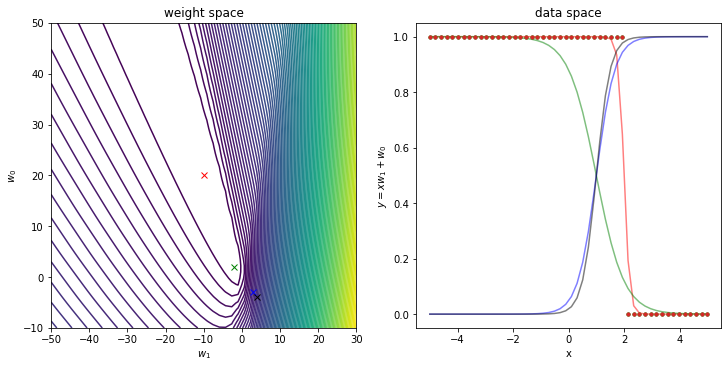

In [9]:
x_plus_bias = np.column_stack([x,np.ones(x.shape[0])])
cost_w = lambda param: cost_fn(x_plus_bias, y, param)
model_list = [(-10, 20), (-2, 2), (3,-3), (4,-4)]
fig, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(10, 5))
plot_contour(cost_w, [-50,30], [-10,50],  50, axes[0])
colors = ['r','g', 'b', 'k']
for i, w in enumerate(model_list):
    axes[0].plot(w[0], w[1], 'x'+colors[i])
    axes[1].plot(x, y, '.')
    axes[1].plot(x, logistic(w[1] + np.dot(w[0], x)), '-'+colors[i], alpha=.5)
axes[0].set_xlabel(r'$w_1$')
axes[0].set_ylabel(r'$w_0$')
axes[0].set_title('weight space')
axes[1].set_xlabel('x')
axes[1].set_ylabel(r'$y=xw_1 + w_0$')
axes[1].set_title('data space')
plt.show()

## Iris dataset
Let's visualize class probabilities for D=2 (plus a bias). 
To be able to use logistic regression we choose two of the three classes in the Iris dataset.

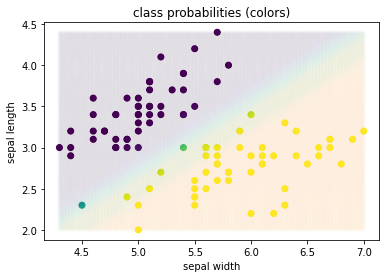

In [13]:
from sklearn import datasets
dataset = datasets.load_iris()
x, y = dataset['data'][:,:2], dataset['target']
x, y = x[y < 2], y[y< 2]
model = LogisticRegression()
yh = model.fit(x,y).predict(x)

x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T
yh_all = model.predict(x_all)
plt.scatter(x[:,0], x[:,1], c=yh, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=yh_all, marker='.', alpha=.01)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.title('class probabilities (colors)')
plt.show()